In [9]:
import torch
import pandas as pd
import os
import numpy as np
import COSMO_TL as ctl
from dask.distributed import Client, LocalCluster, progress
import dask
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interpn
from scipy.interpolate import LinearNDInterpolator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.optimize import curve_fit, minimize, differential_evolution
# get particle swarm optimizer
from pyswarm import pso
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
def get_X_solute(df):
    X = df[['volume_solute', 'area_solute', 'NC_K', 'SIGMA_K','TAU', 'default_error']]
    sig_cols = [col for col in df.columns if 'sigma_solute' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X_solvent(df):
    X = df[['volume_solvent', 'area_solvent','NC_K','SIGMA_K','TAU', 'default_error']]
    sig_cols = [col for col in df.columns if 'sigma_solvent' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X(df):
    X_solute = get_X_solute(df)
    X_solvent = get_X_solvent(df)
    # solvent prop cols = eps,n,alpha,beta,gamma,phi**2,psi**2,beta**2
    solvent_props_names = ['eps', 'n', 'alpha', 'beta', 'gamma', 'phi**2', 'psi**2', 'beta**2']
    solvent_props = df[solvent_props_names].to_numpy()
    X = np.column_stack((X_solute, X_solvent, solvent_props))
    return X
# given a dataframe return a dataframe with the mean value for all columns with error in the name
# grouped by SoluteName
def get_mean_df(df):
    df2 = df.copy()
    original_columns = list(df2.columns)
    print(original_columns)
    cols = [col for col in df2.columns if 'error' in col]
    original_columns = [col for col in original_columns if col not in cols]
    df3 = df2.groupby(['SoluteName', 'NC_K','SIGMA_K','TAU'])[cols].mean()
    df3 = df3.reset_index()
    # return a dataframe with the unique values in SoluteName and the mean values for all columns with error in the name
    # get all the other colums  from the original dataframe
    df4 = df2[original_columns]
    df4 = df4.reset_index(drop=True)
    df5 = pd.merge(df4, df3, on=['SoluteName', 'NC_K','SIGMA_K','TAU'])
    df5 = df5.drop_duplicates()
    return df5
df = pd.read_csv('../data/vaspsol_data_3_2_2023.csv')
print(len(df))
df['error'] = df['error'].abs()
df = df[df['error'] < 10]
df = df[df['Solvent'] == 'water']
df = df[df['Charge'] == 0]
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
default_df = df[(df['NC_K'] == NC_K_default) & (df['SIGMA_K'] == SIGMA_K_default) & (df['TAU'] == TAU_default)]
default_df
df_to_append = default_df[['SoluteName','error']]
# rename error to default_error
df_to_append = df_to_append.rename(columns={'error': 'default_error'})
df_to_append
# match up the default error back to the original dataframe
df = pd.merge(df, df_to_append, on=['SoluteName'])
# this expanded the number of rows in the dataframe. This is not what we want
df = df.drop_duplicates('Unnamed: 0')
df
# how many unique values of NC_K, SIGMA_K, TAU are there?
df[['NC_K', 'SIGMA_K', 'TAU']].drop_duplicates()
print(len(df['NC_K'].unique())), print(len(df['SIGMA_K'].unique())), print(len(df['TAU'].unique()))

NC_K_opt = 0.003
SIGMA_K_opt = 0.64203644
TAU_opt = 0.0007722
df_opt = df[(df['NC_K'] == NC_K_opt) & (df['SIGMA_K'] == SIGMA_K_opt) & (df['TAU'] == TAU_opt)]
df_opt

n = 100
# get the lowest error for each solute, NC_K, SIGMA_K, TAU. this is will df2
df2 = df.groupby(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU'])['error'].min().reset_index()[['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error']]
# make sure each group has the same unique FileHandle. Use df2 to construct which FileHandles to include
df_grouped = df2.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get groups with at least 5 members
df_filtered = df_grouped.filter(lambda x: len(x) >= n)
df_filtered = df_filtered.reset_index(drop=True)
# # create a dataframe with the mean values for all the columns grouping by NC_K, SIGMA_K, TAU. Remove the SoluteName column. use get_level_values to get the unique values of NC_K, SIGMA_K, TAU
df_temp = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']].drop_duplicates()
# print the number of observations of each group
counts = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).count()['error']
# lets reset the df_temp dataframe to have a normal index and make the current indicies into columns
df_temp = df_temp.reset_index(drop=True)
# add the counts column to the dataframe
df_temp['counts'] = counts.values
# get the params of the minimum error
df_temp = df_temp.sort_values(by=['error'])
params_min = df_temp.iloc[0][['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
solutes_min = df[(df['NC_K'] == params_min[0]) & (df['SIGMA_K'] == params_min[1]) & (df['TAU'] == params_min[2])]['SoluteName'].unique()
# get the unique solutes in params_min and the info of params min
# first pretty print a table of params min 
print('NC_K: ', params_min[0], 'SIGMA_K: ', params_min[1], 'TAU: ', params_min[2])
print('error: ', df_temp.iloc[0]['error'], 'counts: ', df_temp.iloc[0]['counts'])
print('solutes: ', len(solutes_min))
# pretty print the number of solutes in solutes_min
params = df_temp[['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
# create a df containing the NC_K, SIGMA_K, TAU, and error for the minimum error. again filter to keep the minimum error for each group
dfs_temp = pd.concat([df[(df['NC_K'] == params[i][0]) & (df['SIGMA_K'] == params[i][1]) & (df['TAU'] == params[i][2])] for i in range(len(params))])
# keep only the solutes_min in dfs_temp
#dfs_temp = dfs_temp[dfs_temp['SoluteName'].isin(solutes_min)]
# get the minimum error for each group of NC_K, SIGMA_K, TAU, and SoluteName
dfs_temp = dfs_temp.groupby(['SoluteName', 'NC_K', 'SIGMA_K', 'TAU'])['error'].min().reset_index()[['SoluteName', 'NC_K', 'SIGMA_K', 'TAU', 'error']]
# group by NC_K, SIGMA_K, TAU to get the mean error for each group and add the counts column
# dfs_temp = dfs_temp.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']]
# dfs_temp['counts'] = counts.values
dfs_temp = dfs_temp.sort_values(by=['error'])
stats_df = pd.DataFrame()
dfs_temp_grouped = dfs_temp.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get all the params in the groups
stats_df['NC_K'] = dfs_temp_grouped['NC_K'].unique().apply(lambda x: x[0]).values
stats_df['SIGMA_K'] = dfs_temp_grouped['SIGMA_K'].unique().apply(lambda x: x[0]).values
stats_df['TAU'] = dfs_temp_grouped['TAU'].unique().apply(lambda x: x[0]).values
stats_df['mean_error'] = dfs_temp_grouped['error'].mean().values
stats_df['counts'] = dfs_temp_grouped['error'].count().values
stats_df

6539
453
432
442
NC_K:  0.00366 SIGMA_K:  0.5813 TAU:  0.0009363
error:  1.101976550046077 counts:  217.0
solutes:  217


C:\Users\efons\AppData\Local\Temp\ipykernel_26084\3252882588.py:107: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_temp = df_filtered.groupby(['NC_K', 'SIGMA_K', 'TAU']).mean().reset_index()[['NC_K', 'SIGMA_K', 'TAU','error']].drop_duplicates()


,NC_K,SIGMA_K,TAU,mean_error,counts
0,0.00250,0.600000,0.000525,1.152820,289
1,0.00275,0.660000,0.000472,1.481514,201
2,0.00300,0.642036,0.000772,1.118572,169
3,0.00366,0.581300,0.000936,1.101977,217


C:\Users\efons\AppData\Local\Temp\ipykernel_26084\4076636756.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, label='NC_K: ' + str(param[0]) + ' SIGMA_K: ' + str(param[1]) + ' TAU: ' + str(param[2]))


<AxesSubplot: ylabel='Density'>

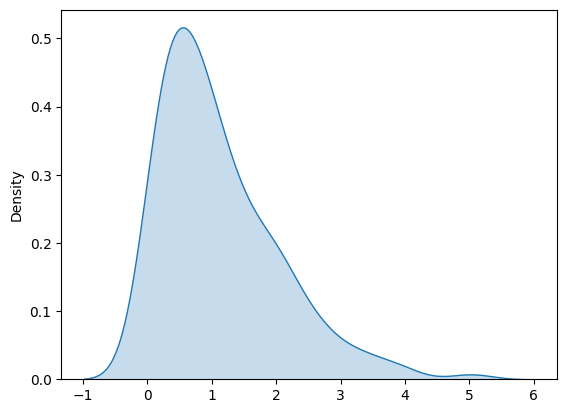

In [10]:
import seaborn as sns
params = stats_df[['NC_K', 'SIGMA_K', 'TAU']].to_numpy()
param = params[2]
error = df[(df['NC_K'] == param[0]) & (df['SIGMA_K'] == param[1]) & (df['TAU'] == param[2])]['error'].to_numpy()
# use normalized kde using seaborn
sns.kdeplot(error, shade=True, label='NC_K: ' + str(param[0]) + ' SIGMA_K: ' + str(param[1]) + ' TAU: ' + str(param[2]))
# put the params on the plot as a bbox in the top right corner
#plt.text(3, 400, 'NC_K: ' + str(param[0]) + ' SIGMA_K: ' + str(param[1]) + ' TAU: ' + str(param[2]), bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

C:\Users\efons\AppData\Local\Temp\ipykernel_26084\685405591.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True,
C:\Users\efons\AppData\Local\Temp\ipykernel_26084\685405591.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True,
C:\Users\efons\AppData\Local\Temp\ipykernel_26084\685405591.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True,
C:\Users\efons\AppData\Local\Temp\ipykernel_26084\685405591.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot

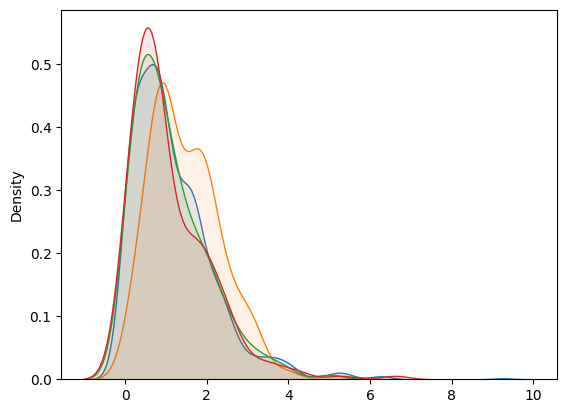

In [16]:
# plot all the kdes of each group in stats_df
for params in stats_df[['NC_K', 'SIGMA_K', 'TAU']].to_numpy():
    error = df[(df['NC_K'] == params[0]) & (df['SIGMA_K'] == params[1]) & (df['TAU'] == params[2])]['error'].to_numpy()
    sns.kdeplot(error, shade=True, 
                #edgecolor='black',
                alpha=0.1, 
                label='NC_K: ' + str(params[0]) + ' SIGMA_K: ' + str(params[1]) + ' TAU: ' + str(params[2]))
#plt.legend(alpha=0.5)

C:\Users\efons\AppData\Local\Temp\ipykernel_26084\221816035.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(i['change'], shade=True,
C:\Users\efons\AppData\Local\Temp\ipykernel_26084\221816035.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(i['change'], shade=True,
C:\Users\efons\AppData\Local\Temp\ipykernel_26084\221816035.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(i['change'], shade=True,
C:\Users\efons\AppData\Local\Temp\ipykernel_26084\221816035.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(i['change'], shade=Tr

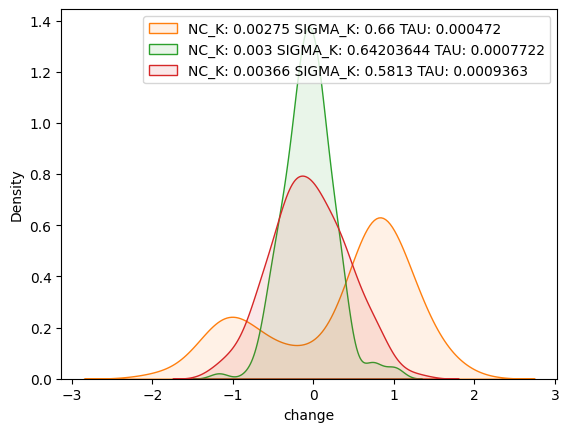

In [19]:
dfs = [df[(df['NC_K'] == params[0]) & (df['SIGMA_K'] == params[1]) & (df['TAU'] == params[2])] for params in stats_df[['NC_K', 'SIGMA_K', 'TAU']].to_numpy()]
# drop duplicates in default_df keeping the row with the smallest value in the error column
dfs = [df.drop_duplicates(subset=['SoluteName'], keep='first') for df in dfs]
#default_df = default_df.drop_duplicates(subset=['SoluteName'], keep='first')
#default_errors = default_df[['SoluteName','error']]
for i in dfs:
    i['change'] = i['error'] - i['default_error']
    sns.kdeplot(i['change'], shade=True,   
                #edgecolor='black',
                alpha=0.1,
                label='NC_K: ' + str(i['NC_K'].unique()[0]) + ' SIGMA_K: ' + str(i['SIGMA_K'].unique()[0]) + ' TAU: ' + str(i['TAU'].unique()[0]))
plt.legend()

<AxesSubplot: >

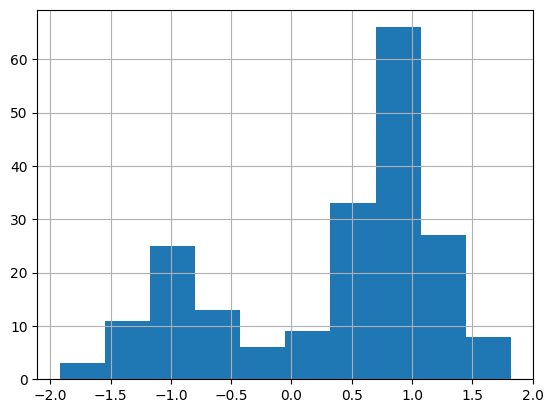

In [13]:
dfs[1]['change'].hist()

In [7]:
dfs[0]['error']

1385     4.607730
5763     3.673704
7309     6.076757
7341     4.524167
7397     8.111012
10593    5.353302
10625    3.539434
10675    4.914268
10724    2.546599
10797    8.517927
10810    4.148003
10842    2.839387
10874    5.463385
10906    9.358410
10918    6.192474
11362    0.205261
11387    3.513104
12415    6.200478
12690    5.324900
12722    0.193292
12771    3.700377
12795    7.215195
12804    5.870405
12934    6.022572
15520    4.934716
15545    6.213959
15581    5.684646
15627    6.618856
19614    2.987199
19692    5.659435
19731    3.403211
19763    2.888588
19787    3.629471
23210    2.855665
23298    4.142344
23319    4.761641
23340    7.238128
23361    6.003650
23382    3.334372
23403    5.910385
24147    3.307913
24903    5.694754
26915    3.047957
27859    4.722372
27880    6.817371
27886    6.669069
27907    2.925686
27931    0.920210
27952    8.515843
Name: error, dtype: float64